In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from datetime import datetime
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tesla_stocks = pd.read_csv('/home/jovyan/courses-txg/RNN/part2/data/tesla_stocks.csv')

In [3]:
tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)

In [4]:
#資料共有六個資訊，日期、開盤、當日最高、當日最低、收盤、成交量
tesla_stocks.head()

,Date,Open,High,Low,Close,Volume
0,2014-08-04,234.38,240.50,233.27,238.52,5967406
1,2014-08-05,237.47,242.99,235.69,238.49,5388581
2,2014-08-06,238.90,251.42,238.58,248.93,9249265
3,2014-08-07,250.12,256.69,249.12,252.39,7478926
4,2014-08-08,251.16,251.76,246.50,248.13,5099061


In [5]:
data_to_use = tesla_stocks.iloc[:,1:6].values

# Scaler

In [6]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use)
scaled_label = scaled_data[:, 3]

In [7]:
print("std: ", scaled_label.std())
print("mean: ", scaled_label.mean())

std:  0.9999999999999999
mean:  4.69935671799008e-16


# Plot all feature

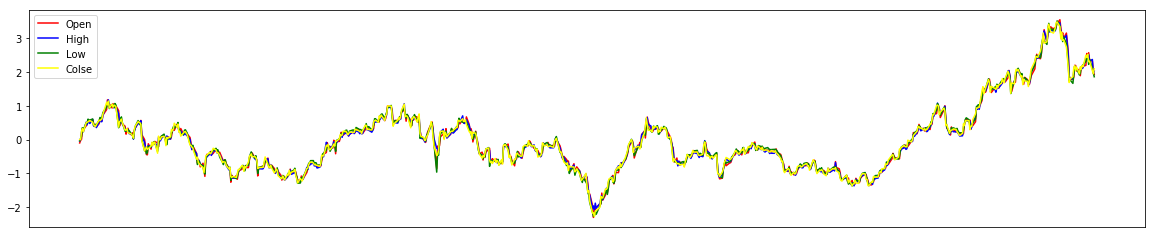

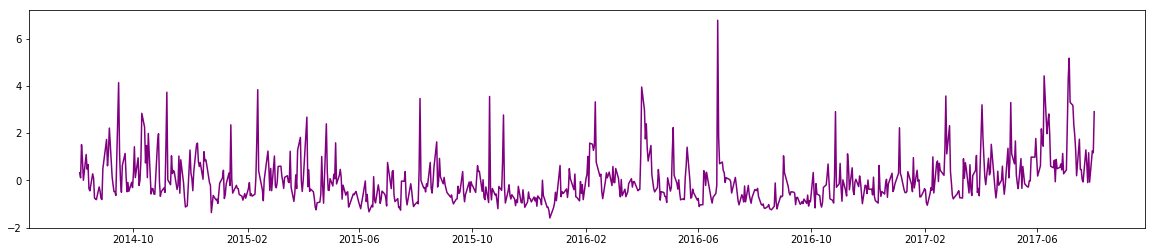

In [8]:
'Take feature Open, High, Low, Close, Volume'
plt.figure(figsize=(20, 4))
plt.plot(tesla_stocks.Date, scaled_data[:, 0], color='red', label='Open')
plt.plot(tesla_stocks.Date, scaled_data[:, 1], color='blue', label='High')
plt.plot(tesla_stocks.Date, scaled_data[:, 2], color='green', label='Low')
plt.plot(tesla_stocks.Date, scaled_data[:, 3], color='yellow', label='Colse')
plt.xticks([])
plt.legend()
plt.show()
plt.figure(figsize=(20, 4))
plt.plot(tesla_stocks.Date, scaled_data[:, 4], color='purple', label='Volume')
plt.show()

# Conifg

In [9]:
window_size = 7
n_features = 5
n_classes = 1
hidden_layer_size = 512
number_of_layer = 1
dropout = True
dropout_rate = 0.8
learning_rate = 0.001
batch_size = 8
epochs = 200

# Data preprocessing

In [10]:
def window_data(data, label, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i: i + window_size])
        y.append([label[i + window_size]])
        i += 1
    
    assert len(X) == len(y)

    return X, y

In [11]:
X, y = window_data(scaled_data, scaled_label, window_size)
X = np.expand_dims(X, axis=4)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [12]:
X_train = np.array(X[: 700])
X_test = np.array(X[700: ])
y_train = np.array(y[: 700])
y_test = np.array(y[700: ])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 7, 5, 1)
y_train size: (700, 1)
X_test size: (49, 7, 5, 1)
y_test size: (49, 1)


# Create Conv2d

In [13]:
import tensorflow as tf

In [14]:
def output_layer(conv_layer, out_size):
    x = tf.reduce_mean(conv_layer, axis=[1])
    output = tf.layers.dense(x, out_size)
    
    return output

In [15]:
def opt_loss(logits, targets, learning_rate):
    loss = tf.reduce_mean(tf.pow(logits-targets, 2)) / batch_size
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_opti = optimizer.minimize(loss)
    
    return loss, train_opti

# Graph

In [16]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    with tf.name_scope('inputs'):
        inputs = tf.placeholder(tf.float32, shape=[None, window_size, 5, 1], name='inputs')
        targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')
        
    with tf.variable_scope('conv2d_layer1'):
        conv2d_layer1 = tf.layers.conv2d(inputs, filters=32, kernel_size=(3, 5), activation='relu')
    with tf.variable_scope('conv2d_layer2'):
        conv2d_layer2 = tf.layers.conv2d(conv2d_layer1, filters=64, kernel_size=(3, 1), activation='relu')
    
    with tf.variable_scope('output_layer'):
        logits = output_layer(conv2d_layer2, n_classes)
        
    with tf.name_scope('opt_loss'):
        loss, opti = opt_loss(logits, targets, learning_rate)
        
    init = tf.global_variables_initializer()

In [18]:
sess.run(init)

for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = sess.run([logits, loss, opti], feed_dict={inputs: X_batch, targets: y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.017636796459555626
Epoch 30/200  Current loss: 0.006647535599768162
Epoch 60/200  Current loss: 0.006081514526158571
Epoch 90/200  Current loss: 0.005301841534674168
Epoch 120/200  Current loss: 0.004675641655921936
Epoch 150/200  Current loss: 0.004451897460967302
Epoch 180/200  Current loss: 0.004218955058604479


In [19]:
#Training set預測結果
training_set_pred = np.array([])
for i in range(len(X_train)):
    o = sess.run(logits, feed_dict={inputs:X_train[i:i+1]})
    training_set_pred = np.append(training_set_pred, o)

In [20]:
#Testing set預測結果
testing_set_pred = np.array([])
for i in range(len(X_test)):
    o = sess.run(logits, feed_dict={inputs:X_test[i:i+1]})
    testing_set_pred = np.append(testing_set_pred, o)  

In [22]:
#把資料放到list裡面準備畫圖
#因為我們是用前七天預測第8天股價，故前七天設為None
training = [None]*window_size
for i in range(len(X_train)):
    training.append(training_set_pred[i])
testing = [None] * (window_size + len(X_train))
testing_loss = 0
for i in range(len(X_test)):
    testing.append(testing_set_pred[i])
    testing_loss += (testing_set_pred[i] - y_test[i])**2
    training.append(None)
print('testing_loss:', testing_loss / len(X_test))

testing_loss: [0.22054775]


### Plotting predictions from the network

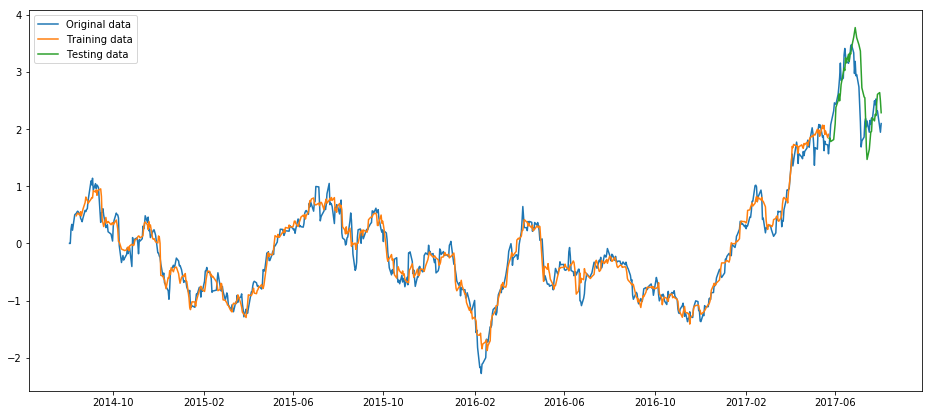

In [23]:
plt.figure(figsize=(16, 7))
plt.plot(tesla_stocks.Date, scaled_label, label='Original data')
plt.plot(tesla_stocks.Date, training, label='Training data')
plt.plot(tesla_stocks.Date, testing, label='Testing data')
plt.legend()
plt.show()

In [24]:
sess.close()